# Generative Adversarial Network

In [1]:
import warnings
import tensorflow as tf

warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

In [2]:
import ndjson
import numpy as np
import matplotlib.pyplot as plt

from os import mkdir, walk
from os.path import join, exists
from PIL import Image, ImageDraw

from src.model.GAN import GAN

2023-02-09 06:05:06.105102: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-09 06:05:06.198632: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-09 06:05:06.201874: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-09 06:05:06.201888: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

## Data

### Load Training Data

In [3]:
def load_images_from_npy_file(directory, n_images):
    mypath = join("./data", directory)
    txt_name_list = []
    for (dirpath, dirnames, filenames) in walk(mypath):
        for f in filenames:
            if f != '.DS_Store':
                txt_name_list.append(f)
                break

    slice_train = int(n_images/len(txt_name_list))
    i = 0
    seed = np.random.randint(1, 10e6)

    for txt_name in txt_name_list:
        txt_path = join(mypath,txt_name)
        x = np.load(txt_path)
        x = (x.astype('float32') - 127.5) / 127.5
        
        x = x.reshape(x.shape[0], 28, 28, 1)
        
        y = [i] * len(x)  
        
        np.random.seed(seed)
        np.random.shuffle(x)
        
        np.random.seed(seed)
        np.random.shuffle(y)

        x = x[:slice_train]
        y = y[:slice_train]
        
        if i != 0: 
            x_total = np.concatenate((x,x_total), axis=0)
            y_total = np.concatenate((y,y_total), axis=0)
        else:
            x_total = x
            y_total = y
        i += 1
        
    return x_total, y_total

In [4]:
(x_train, y_train) = load_images_from_npy_file('mona_lisa', 80000)

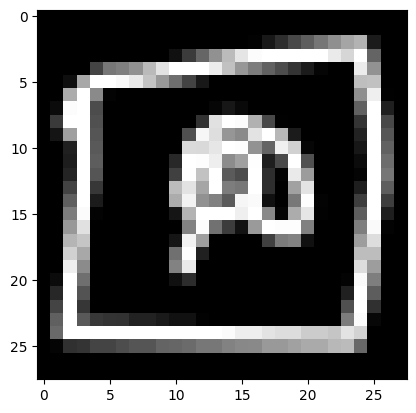

In [5]:
plt.imshow(x_train[400,:,:,0], cmap = 'gray')

## Display Some Images

## GAN Architecture

In [6]:
gan = GAN(
    input_dim = (28,28,1),
    discriminator_conv_filters = [64,64,128,128],
    discriminator_conv_kernel_size = [5,5,5,5],
    discriminator_conv_strides = [2,2,2,1],
    discriminator_batch_norm_momentum = None,
    discriminator_activation = 'leaky_relu',
    discriminator_dropout_rate = 0.4,
    discriminator_learning_rate = 0.0008,
    generator_initial_dense_layer_size = (7, 7, 64),
    generator_upsample = [2,2, 1, 1],
    generator_conv_filters = [128,64, 64,1],
    generator_conv_kernel_size = [5,5,5,5],
    generator_conv_strides = [1,1, 1, 1],
    generator_batch_norm_momentum = 0.9,
    generator_activation = 'leaky_relu',
    generator_dropout_rate = None,
    generator_learning_rate = 0.0004,
    optimizer = 'rmsprop',
    z_dim = 100,
)

2023-02-09 06:05:08.276066: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-09 06:05:08.276103: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-09 06:05:08.276118: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (37427d3bf801): /proc/driver/nvidia/version does not exist
2023-02-09 06:05:08.276295: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
gan.discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 discriminator_input (InputL  [(None, 28, 28, 1)]      0         
 ayer)                                                           
                                                                 
 discriminator_conv0 (Conv2D  (None, 14, 14, 64)       1664      
 )                                                               
                                                                 
 activation (Activation)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 discriminator_conv1 (Conv2D  (None, 7, 7, 64)         102464    
 )                                                               
                                                             

In [8]:
gan.generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator_input (InputLayer  [(None, 100)]            0         
 )                                                               
                                                                 
 dense_1 (Dense)             (None, 3136)              316736    
                                                                 
 batch_normalization (BatchN  (None, 3136)             12544     
 ormalization)                                                   
                                                                 
 activation_4 (Activation)   (None, 3136)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 64)       0   

## Train GAN

In [9]:
BATCH_SIZE = 64
EPOCHS = 5000
PRINT_EVERY_N_BATCHES = 5

In [10]:
gan.train(    
    x_train,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    print_every_n_batches = PRINT_EVERY_N_BATCHES,
    log=False
)

2/2 [==============================] - 0s 44ms/step


2023-02-09 06:05:12.193 | INFO     | src.model.GAN:train:260 - 0 [D loss: (0.768)(R 0.681, F 0.855)] [D acc: (0.469)(0.938, 0.000)] [G loss: 0.685] [G acc: 1.000]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:05:12           64
config.j

2023-02-09 06:05:14.608 | INFO     | src.model.GAN:train:260 - 5 [D loss: (0.622)(R 0.297, F 0.947)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.133] [G acc: 1.000]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:05:14           64
config.j

2023-02-09 06:05:16.983 | INFO     | src.model.GAN:train:260 - 10 [D loss: (0.720)(R 0.510, F 0.930)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.540] [G acc: 1.000]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:05:17           64
config.j

2023-02-09 06:05:19.360 | INFO     | src.model.GAN:train:260 - 15 [D loss: (0.595)(R 0.435, F 0.755)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.689] [G acc: 0.828]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:05:19           64
config.j

2023-02-09 06:05:21.774 | INFO     | src.model.GAN:train:260 - 20 [D loss: (0.225)(R 0.008, F 0.442)] [D acc: (1.000)(1.000, 1.000)] [G loss: 2.466] [G acc: 0.000]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:05:22           64
config.j

2023-02-09 06:05:24.194 | INFO     | src.model.GAN:train:260 - 25 [D loss: (0.675)(R 0.440, F 0.910)] [D acc: (0.484)(0.969, 0.000)] [G loss: 0.641] [G acc: 0.922]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:05:24           64
config.j

2023-02-09 06:05:26.687 | INFO     | src.model.GAN:train:260 - 30 [D loss: (0.534)(R 0.357, F 0.712)] [D acc: (0.797)(1.000, 0.594)] [G loss: 1.021] [G acc: 0.000]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:05:26           64
config.j

2023-02-09 06:05:29.182 | INFO     | src.model.GAN:train:260 - 35 [D loss: (0.340)(R 0.443, F 0.237)] [D acc: (0.914)(0.828, 1.000)] [G loss: 0.199] [G acc: 1.000]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:05:29           64
config.j

2023-02-09 06:05:31.626 | INFO     | src.model.GAN:train:260 - 40 [D loss: (0.007)(R 0.010, F 0.004)] [D acc: (1.000)(1.000, 1.000)] [G loss: 0.003] [G acc: 1.000]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:05:31           64
config.j

2023-02-09 06:05:34.019 | INFO     | src.model.GAN:train:260 - 45 [D loss: (2.128)(R 0.354, F 3.902)] [D acc: (0.422)(0.844, 0.000)] [G loss: 0.639] [G acc: 0.828]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:05:34           64
config.j

2023-02-09 06:05:36.461 | INFO     | src.model.GAN:train:260 - 50 [D loss: (0.652)(R 0.673, F 0.631)] [D acc: (0.586)(0.641, 0.531)] [G loss: 2.056] [G acc: 0.078]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:05:36           64
config.j

2023-02-09 06:05:39.043 | INFO     | src.model.GAN:train:260 - 55 [D loss: (0.667)(R 0.702, F 0.632)] [D acc: (0.680)(0.453, 0.906)] [G loss: 0.885] [G acc: 0.000]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:05:39           64
config.j

2023-02-09 06:05:41.537 | INFO     | src.model.GAN:train:260 - 60 [D loss: (0.646)(R 0.732, F 0.560)] [D acc: (0.641)(0.438, 0.844)] [G loss: 0.931] [G acc: 0.188]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:05:41           64
config.j

2023-02-09 06:05:44.058 | INFO     | src.model.GAN:train:260 - 65 [D loss: (0.184)(R 0.325, F 0.043)] [D acc: (0.953)(0.906, 1.000)] [G loss: 0.182] [G acc: 1.000]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:05:44           64
config.j

2023-02-09 06:05:46.660 | INFO     | src.model.GAN:train:260 - 70 [D loss: (0.715)(R 0.492, F 0.937)] [D acc: (0.492)(0.984, 0.000)] [G loss: 0.641] [G acc: 0.719]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:05:46           64
config.j

2023-02-09 06:05:49.274 | INFO     | src.model.GAN:train:260 - 75 [D loss: (0.695)(R 0.608, F 0.781)] [D acc: (0.523)(0.891, 0.156)] [G loss: 0.790] [G acc: 0.141]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:05:49           64
config.j

2023-02-09 06:05:51.899 | INFO     | src.model.GAN:train:260 - 80 [D loss: (0.583)(R 0.625, F 0.541)] [D acc: (0.828)(0.719, 0.938)] [G loss: 0.692] [G acc: 0.578]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:05:52           64
config.j

2023-02-09 06:05:54.492 | INFO     | src.model.GAN:train:260 - 85 [D loss: (0.723)(R 0.600, F 0.845)] [D acc: (0.438)(0.797, 0.078)] [G loss: 0.776] [G acc: 0.203]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:05:54           64
config.j

2023-02-09 06:05:57.191 | INFO     | src.model.GAN:train:260 - 90 [D loss: (0.691)(R 0.640, F 0.743)] [D acc: (0.500)(0.797, 0.203)] [G loss: 0.645] [G acc: 0.875]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:05:57           64
config.j

2023-02-09 06:05:59.898 | INFO     | src.model.GAN:train:260 - 95 [D loss: (0.672)(R 0.576, F 0.767)] [D acc: (0.531)(0.938, 0.125)] [G loss: 0.654] [G acc: 0.703]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:06:00           64
config.j

2023-02-09 06:06:02.563 | INFO     | src.model.GAN:train:260 - 100 [D loss: (0.667)(R 0.547, F 0.786)] [D acc: (0.539)(0.922, 0.156)] [G loss: 0.758] [G acc: 0.109]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:06:02           64
config.j

2023-02-09 06:06:05.046 | INFO     | src.model.GAN:train:260 - 105 [D loss: (0.676)(R 0.643, F 0.709)] [D acc: (0.531)(0.672, 0.391)] [G loss: 0.733] [G acc: 0.125]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:06:05           64
config.j

2023-02-09 06:06:07.617 | INFO     | src.model.GAN:train:260 - 110 [D loss: (0.643)(R 0.589, F 0.696)] [D acc: (0.695)(0.844, 0.547)] [G loss: 0.736] [G acc: 0.047]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:06:07           64
config.j

2023-02-09 06:06:10.488 | INFO     | src.model.GAN:train:260 - 115 [D loss: (0.675)(R 0.654, F 0.697)] [D acc: (0.523)(0.531, 0.516)] [G loss: 0.665] [G acc: 0.625]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:06:10           64
config.j

2023-02-09 06:06:13.434 | INFO     | src.model.GAN:train:260 - 120 [D loss: (0.566)(R 0.463, F 0.669)] [D acc: (0.797)(0.922, 0.672)] [G loss: 0.876] [G acc: 0.016]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:06:13           64
config.j

2023-02-09 06:06:16.202 | INFO     | src.model.GAN:train:260 - 125 [D loss: (0.668)(R 0.584, F 0.751)] [D acc: (0.484)(0.734, 0.234)] [G loss: 0.772] [G acc: 0.250]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:06:16           64
config.j

2023-02-09 06:06:18.799 | INFO     | src.model.GAN:train:260 - 130 [D loss: (0.620)(R 0.350, F 0.891)] [D acc: (0.531)(0.953, 0.109)] [G loss: 0.702] [G acc: 0.406]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:06:19           64
config.j

2023-02-09 06:06:21.346 | INFO     | src.model.GAN:train:260 - 135 [D loss: (0.605)(R 0.499, F 0.712)] [D acc: (0.711)(0.938, 0.484)] [G loss: 0.796] [G acc: 0.094]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:06:21           64
config.j

2023-02-09 06:06:23.945 | INFO     | src.model.GAN:train:260 - 140 [D loss: (0.585)(R 0.422, F 0.747)] [D acc: (0.625)(0.938, 0.312)] [G loss: 0.786] [G acc: 0.078]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:06:24           64
config.j

2023-02-09 06:06:26.529 | INFO     | src.model.GAN:train:260 - 145 [D loss: (0.667)(R 0.549, F 0.786)] [D acc: (0.562)(0.844, 0.281)] [G loss: 0.691] [G acc: 0.438]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:06:26           64
config.j

2023-02-09 06:06:29.019 | INFO     | src.model.GAN:train:260 - 150 [D loss: (0.637)(R 0.453, F 0.820)] [D acc: (0.547)(0.797, 0.297)] [G loss: 0.786] [G acc: 0.125]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:06:29           64
config.j

2023-02-09 06:06:31.634 | INFO     | src.model.GAN:train:260 - 155 [D loss: (0.572)(R 0.295, F 0.849)] [D acc: (0.531)(0.766, 0.297)] [G loss: 0.726] [G acc: 0.250]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:06:31           64
config.j

2023-02-09 06:06:34.467 | INFO     | src.model.GAN:train:260 - 160 [D loss: (0.726)(R 0.626, F 0.827)] [D acc: (0.430)(0.797, 0.062)] [G loss: 0.622] [G acc: 0.844]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:06:34           64
config.j

2023-02-09 06:06:37.197 | INFO     | src.model.GAN:train:260 - 165 [D loss: (0.609)(R 0.535, F 0.682)] [D acc: (0.688)(0.812, 0.562)] [G loss: 0.819] [G acc: 0.031]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:06:37           64
config.j

2023-02-09 06:06:40.001 | INFO     | src.model.GAN:train:260 - 170 [D loss: (0.666)(R 0.614, F 0.717)] [D acc: (0.594)(0.734, 0.453)] [G loss: 0.673] [G acc: 0.656]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:06:40           64
config.j

2023-02-09 06:06:42.935 | INFO     | src.model.GAN:train:260 - 175 [D loss: (0.676)(R 0.629, F 0.723)] [D acc: (0.484)(0.656, 0.312)] [G loss: 0.719] [G acc: 0.219]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:06:43           64
config.j

2023-02-09 06:06:45.500 | INFO     | src.model.GAN:train:260 - 180 [D loss: (0.579)(R 0.430, F 0.727)] [D acc: (0.711)(0.797, 0.625)] [G loss: 0.791] [G acc: 0.062]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:06:45           64
config.j

2023-02-09 06:06:48.104 | INFO     | src.model.GAN:train:260 - 185 [D loss: (0.526)(R 0.359, F 0.693)] [D acc: (0.727)(0.812, 0.641)] [G loss: 0.968] [G acc: 0.000]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:06:48           64
config.j

2023-02-09 06:06:50.732 | INFO     | src.model.GAN:train:260 - 190 [D loss: (0.785)(R 0.441, F 1.130)] [D acc: (0.430)(0.734, 0.125)] [G loss: 0.606] [G acc: 0.688]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:06:51           64
config.j

2023-02-09 06:06:53.332 | INFO     | src.model.GAN:train:260 - 195 [D loss: (0.698)(R 0.515, F 0.881)] [D acc: (0.523)(0.781, 0.266)] [G loss: 0.945] [G acc: 0.000]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:06:53           64
config.j

2023-02-09 06:06:55.966 | INFO     | src.model.GAN:train:260 - 200 [D loss: (0.522)(R 0.322, F 0.722)] [D acc: (0.773)(0.859, 0.688)] [G loss: 0.596] [G acc: 0.594]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:06:56           64
config.j

2023-02-09 06:06:58.567 | INFO     | src.model.GAN:train:260 - 205 [D loss: (0.554)(R 0.464, F 0.644)] [D acc: (0.773)(0.859, 0.688)] [G loss: 0.955] [G acc: 0.031]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:06:58           64
config.j

2023-02-09 06:07:01.107 | INFO     | src.model.GAN:train:260 - 210 [D loss: (0.379)(R 0.281, F 0.476)] [D acc: (0.852)(0.859, 0.844)] [G loss: 1.361] [G acc: 0.031]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:07:01           64
config.j

2023-02-09 06:07:03.763 | INFO     | src.model.GAN:train:260 - 215 [D loss: (0.648)(R 0.160, F 1.136)] [D acc: (0.633)(0.922, 0.344)] [G loss: 1.027] [G acc: 0.016]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:07:04           64
config.j

2023-02-09 06:07:06.357 | INFO     | src.model.GAN:train:260 - 220 [D loss: (0.647)(R 0.590, F 0.705)] [D acc: (0.570)(0.594, 0.547)] [G loss: 0.879] [G acc: 0.109]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:07:06           64
config.j

2023-02-09 06:07:08.910 | INFO     | src.model.GAN:train:260 - 225 [D loss: (0.587)(R 0.470, F 0.704)] [D acc: (0.656)(0.812, 0.500)] [G loss: 0.761] [G acc: 0.266]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:07:09           64
config.j

2023-02-09 06:07:11.535 | INFO     | src.model.GAN:train:260 - 230 [D loss: (0.626)(R 0.522, F 0.730)] [D acc: (0.664)(0.797, 0.531)] [G loss: 0.748] [G acc: 0.125]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:07:11           64
config.j

2023-02-09 06:07:14.078 | INFO     | src.model.GAN:train:260 - 235 [D loss: (0.592)(R 0.416, F 0.769)] [D acc: (0.602)(0.812, 0.391)] [G loss: 0.858] [G acc: 0.016]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:07:14           64
config.j

2023-02-09 06:07:16.588 | INFO     | src.model.GAN:train:260 - 240 [D loss: (0.509)(R 0.294, F 0.725)] [D acc: (0.773)(0.875, 0.672)] [G loss: 0.925] [G acc: 0.000]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:07:16           64
config.j

2023-02-09 06:07:19.156 | INFO     | src.model.GAN:train:260 - 245 [D loss: (0.544)(R 0.347, F 0.741)] [D acc: (0.758)(0.859, 0.656)] [G loss: 0.894] [G acc: 0.000]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:07:19           64
config.j

2023-02-09 06:07:21.665 | INFO     | src.model.GAN:train:260 - 250 [D loss: (0.647)(R 0.318, F 0.977)] [D acc: (0.547)(0.891, 0.203)] [G loss: 0.866] [G acc: 0.031]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:07:21           64
config.j

2023-02-09 06:07:24.152 | INFO     | src.model.GAN:train:260 - 255 [D loss: (0.643)(R 0.434, F 0.853)] [D acc: (0.633)(0.797, 0.469)] [G loss: 1.041] [G acc: 0.000]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:07:24           64
config.j

2023-02-09 06:07:26.706 | INFO     | src.model.GAN:train:260 - 260 [D loss: (0.579)(R 0.433, F 0.725)] [D acc: (0.664)(0.891, 0.438)] [G loss: 0.837] [G acc: 0.047]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:07:27           64
config.j

2023-02-09 06:07:29.335 | INFO     | src.model.GAN:train:260 - 265 [D loss: (0.405)(R 0.274, F 0.536)] [D acc: (0.844)(0.812, 0.875)] [G loss: 1.217] [G acc: 0.000]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:07:29           64
config.j

2023-02-09 06:07:31.904 | INFO     | src.model.GAN:train:260 - 270 [D loss: (0.822)(R 0.408, F 1.236)] [D acc: (0.602)(0.812, 0.391)] [G loss: 0.902] [G acc: 0.125]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:07:32           64
config.j

2023-02-09 06:07:34.488 | INFO     | src.model.GAN:train:260 - 275 [D loss: (0.614)(R 0.617, F 0.611)] [D acc: (0.734)(0.625, 0.844)] [G loss: 0.909] [G acc: 0.031]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:07:34           64
config.j

2023-02-09 06:07:37.014 | INFO     | src.model.GAN:train:260 - 280 [D loss: (0.578)(R 0.505, F 0.651)] [D acc: (0.680)(0.734, 0.625)] [G loss: 0.923] [G acc: 0.094]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:07:37           64
config.j

2023-02-09 06:07:39.472 | INFO     | src.model.GAN:train:260 - 285 [D loss: (0.740)(R 0.364, F 1.116)] [D acc: (0.602)(0.891, 0.312)] [G loss: 1.098] [G acc: 0.016]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:07:39           64
config.j

2023-02-09 06:07:42.037 | INFO     | src.model.GAN:train:260 - 290 [D loss: (0.583)(R 0.385, F 0.781)] [D acc: (0.648)(0.891, 0.406)] [G loss: 1.125] [G acc: 0.047]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:07:42           64
config.j

2023-02-09 06:07:44.651 | INFO     | src.model.GAN:train:260 - 295 [D loss: (0.619)(R 0.389, F 0.848)] [D acc: (0.688)(0.766, 0.609)] [G loss: 0.874] [G acc: 0.172]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:07:44           64
config.j

2023-02-09 06:07:47.416 | INFO     | src.model.GAN:train:260 - 300 [D loss: (0.609)(R 0.473, F 0.745)] [D acc: (0.648)(0.828, 0.469)] [G loss: 0.992] [G acc: 0.016]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:07:47           64
config.j

2023-02-09 06:07:50.107 | INFO     | src.model.GAN:train:260 - 305 [D loss: (0.583)(R 0.476, F 0.690)] [D acc: (0.711)(0.766, 0.656)] [G loss: 0.963] [G acc: 0.016]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:07:50           64
config.j

2023-02-09 06:07:52.769 | INFO     | src.model.GAN:train:260 - 310 [D loss: (0.538)(R 0.541, F 0.535)] [D acc: (0.797)(0.719, 0.875)] [G loss: 1.459] [G acc: 0.016]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:07:53           64
config.j

2023-02-09 06:07:55.334 | INFO     | src.model.GAN:train:260 - 315 [D loss: (0.502)(R 0.434, F 0.569)] [D acc: (0.766)(0.750, 0.781)] [G loss: 1.215] [G acc: 0.078]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:07:55           64
config.j

2023-02-09 06:07:58.001 | INFO     | src.model.GAN:train:260 - 320 [D loss: (0.601)(R 0.518, F 0.685)] [D acc: (0.672)(0.719, 0.625)] [G loss: 1.006] [G acc: 0.047]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:07:58           64
config.j

2023-02-09 06:08:00.553 | INFO     | src.model.GAN:train:260 - 325 [D loss: (0.604)(R 0.538, F 0.669)] [D acc: (0.648)(0.656, 0.641)] [G loss: 1.056] [G acc: 0.047]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:08:00           64
config.j

2023-02-09 06:08:03.259 | INFO     | src.model.GAN:train:260 - 330 [D loss: (0.615)(R 0.584, F 0.645)] [D acc: (0.641)(0.625, 0.656)] [G loss: 1.046] [G acc: 0.062]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:08:03           64
config.j

2023-02-09 06:08:05.779 | INFO     | src.model.GAN:train:260 - 335 [D loss: (0.632)(R 0.663, F 0.602)] [D acc: (0.641)(0.547, 0.734)] [G loss: 0.955] [G acc: 0.078]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:08:06           64
config.j

2023-02-09 06:08:08.512 | INFO     | src.model.GAN:train:260 - 340 [D loss: (0.643)(R 0.570, F 0.716)] [D acc: (0.602)(0.719, 0.484)] [G loss: 0.983] [G acc: 0.062]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:08:08           64
config.j

2023-02-09 06:08:11.225 | INFO     | src.model.GAN:train:260 - 345 [D loss: (0.611)(R 0.607, F 0.615)] [D acc: (0.711)(0.609, 0.812)] [G loss: 1.038] [G acc: 0.062]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:08:11           64
config.j

2023-02-09 06:08:13.985 | INFO     | src.model.GAN:train:260 - 350 [D loss: (0.552)(R 0.373, F 0.731)] [D acc: (0.680)(0.828, 0.531)] [G loss: 1.177] [G acc: 0.094]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:08:14           64
config.j

2023-02-09 06:08:16.575 | INFO     | src.model.GAN:train:260 - 355 [D loss: (0.574)(R 0.404, F 0.743)] [D acc: (0.672)(0.797, 0.547)] [G loss: 1.017] [G acc: 0.125]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:08:16           64
config.j

2023-02-09 06:08:19.191 | INFO     | src.model.GAN:train:260 - 360 [D loss: (0.609)(R 0.522, F 0.697)] [D acc: (0.688)(0.703, 0.672)] [G loss: 1.165] [G acc: 0.078]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:08:19           64
config.j

2023-02-09 06:08:21.857 | INFO     | src.model.GAN:train:260 - 365 [D loss: (0.661)(R 0.574, F 0.748)] [D acc: (0.562)(0.625, 0.500)] [G loss: 1.051] [G acc: 0.047]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:08:22           64
config.j

2023-02-09 06:08:24.483 | INFO     | src.model.GAN:train:260 - 370 [D loss: (0.658)(R 0.612, F 0.705)] [D acc: (0.570)(0.547, 0.594)] [G loss: 1.278] [G acc: 0.062]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:08:24           64
config.j

2023-02-09 06:08:27.124 | INFO     | src.model.GAN:train:260 - 375 [D loss: (0.592)(R 0.610, F 0.575)] [D acc: (0.695)(0.641, 0.750)] [G loss: 1.039] [G acc: 0.141]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:08:27           64
config.j

2023-02-09 06:08:29.830 | INFO     | src.model.GAN:train:260 - 380 [D loss: (0.595)(R 0.528, F 0.662)] [D acc: (0.703)(0.781, 0.625)] [G loss: 1.252] [G acc: 0.062]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:08:30           64
config.j

2023-02-09 06:08:32.492 | INFO     | src.model.GAN:train:260 - 385 [D loss: (0.695)(R 0.636, F 0.754)] [D acc: (0.688)(0.672, 0.703)] [G loss: 1.117] [G acc: 0.047]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:08:32           64
config.j

2023-02-09 06:08:35.070 | INFO     | src.model.GAN:train:260 - 390 [D loss: (0.646)(R 0.680, F 0.611)] [D acc: (0.609)(0.500, 0.719)] [G loss: 1.049] [G acc: 0.062]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:08:35           64
config.j

2023-02-09 06:08:37.714 | INFO     | src.model.GAN:train:260 - 395 [D loss: (0.626)(R 0.621, F 0.631)] [D acc: (0.648)(0.578, 0.719)] [G loss: 1.059] [G acc: 0.094]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:08:38           64
config.j

2023-02-09 06:08:40.398 | INFO     | src.model.GAN:train:260 - 400 [D loss: (0.665)(R 0.531, F 0.798)] [D acc: (0.633)(0.703, 0.562)] [G loss: 0.976] [G acc: 0.109]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:08:40           64
config.j

2023-02-09 06:08:43.708 | INFO     | src.model.GAN:train:260 - 405 [D loss: (0.593)(R 0.461, F 0.725)] [D acc: (0.672)(0.750, 0.594)] [G loss: 1.418] [G acc: 0.016]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:08:44           64
config.j

2023-02-09 06:08:46.980 | INFO     | src.model.GAN:train:260 - 410 [D loss: (0.664)(R 0.757, F 0.572)] [D acc: (0.625)(0.469, 0.781)] [G loss: 1.156] [G acc: 0.031]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:08:47           64
config.j

2023-02-09 06:08:49.713 | INFO     | src.model.GAN:train:260 - 415 [D loss: (0.586)(R 0.631, F 0.540)] [D acc: (0.750)(0.672, 0.828)] [G loss: 1.156] [G acc: 0.047]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:08:50           64
config.j

2023-02-09 06:08:52.352 | INFO     | src.model.GAN:train:260 - 420 [D loss: (0.582)(R 0.612, F 0.552)] [D acc: (0.711)(0.578, 0.844)] [G loss: 1.169] [G acc: 0.031]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:08:52           64
config.j

2023-02-09 06:08:55.048 | INFO     | src.model.GAN:train:260 - 425 [D loss: (0.605)(R 0.657, F 0.553)] [D acc: (0.680)(0.594, 0.766)] [G loss: 1.213] [G acc: 0.031]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:08:55           64
config.j

2023-02-09 06:08:57.758 | INFO     | src.model.GAN:train:260 - 430 [D loss: (0.611)(R 0.579, F 0.643)] [D acc: (0.680)(0.625, 0.734)] [G loss: 1.036] [G acc: 0.031]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:08:58           64
config.j

2023-02-09 06:09:00.827 | INFO     | src.model.GAN:train:260 - 435 [D loss: (0.589)(R 0.571, F 0.607)] [D acc: (0.711)(0.656, 0.766)] [G loss: 1.102] [G acc: 0.031]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:09:01           64
config.j

2023-02-09 06:09:03.661 | INFO     | src.model.GAN:train:260 - 440 [D loss: (0.500)(R 0.466, F 0.535)] [D acc: (0.727)(0.656, 0.797)] [G loss: 1.240] [G acc: 0.000]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:09:03           64
config.j

2023-02-09 06:09:06.273 | INFO     | src.model.GAN:train:260 - 445 [D loss: (0.544)(R 0.457, F 0.630)] [D acc: (0.734)(0.688, 0.781)] [G loss: 1.292] [G acc: 0.016]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:09:06           64
config.j

2023-02-09 06:09:08.916 | INFO     | src.model.GAN:train:260 - 450 [D loss: (0.601)(R 0.588, F 0.613)] [D acc: (0.680)(0.578, 0.781)] [G loss: 1.218] [G acc: 0.047]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:09:09           64
config.j

2023-02-09 06:09:11.555 | INFO     | src.model.GAN:train:260 - 455 [D loss: (0.544)(R 0.472, F 0.616)] [D acc: (0.750)(0.734, 0.766)] [G loss: 1.257] [G acc: 0.078]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:09:11           64
config.j

2023-02-09 06:09:14.211 | INFO     | src.model.GAN:train:260 - 460 [D loss: (0.475)(R 0.458, F 0.492)] [D acc: (0.781)(0.672, 0.891)] [G loss: 1.163] [G acc: 0.094]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:09:14           64
config.j

2023-02-09 06:09:16.946 | INFO     | src.model.GAN:train:260 - 465 [D loss: (0.509)(R 0.518, F 0.499)] [D acc: (0.789)(0.688, 0.891)] [G loss: 1.314] [G acc: 0.016]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:09:17           64
config.j

2023-02-09 06:09:19.638 | INFO     | src.model.GAN:train:260 - 470 [D loss: (0.454)(R 0.457, F 0.452)] [D acc: (0.820)(0.750, 0.891)] [G loss: 1.279] [G acc: 0.031]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:09:19           64
config.j

2023-02-09 06:09:22.424 | INFO     | src.model.GAN:train:260 - 475 [D loss: (0.638)(R 0.401, F 0.875)] [D acc: (0.641)(0.766, 0.516)] [G loss: 1.448] [G acc: 0.000]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:09:22           64
config.j

2023-02-09 06:09:25.988 | INFO     | src.model.GAN:train:260 - 480 [D loss: (0.588)(R 0.555, F 0.621)] [D acc: (0.648)(0.578, 0.719)] [G loss: 1.231] [G acc: 0.016]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:09:26           64
config.j

2023-02-09 06:09:29.002 | INFO     | src.model.GAN:train:260 - 485 [D loss: (0.539)(R 0.484, F 0.593)] [D acc: (0.750)(0.719, 0.781)] [G loss: 1.327] [G acc: 0.078]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:09:29           64
config.j

2023-02-09 06:09:32.001 | INFO     | src.model.GAN:train:260 - 490 [D loss: (0.526)(R 0.557, F 0.495)] [D acc: (0.742)(0.625, 0.859)] [G loss: 1.198] [G acc: 0.062]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:09:32           64
config.j

2023-02-09 06:09:34.721 | INFO     | src.model.GAN:train:260 - 495 [D loss: (0.571)(R 0.519, F 0.623)] [D acc: (0.719)(0.656, 0.781)] [G loss: 1.202] [G acc: 0.047]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:09:35           64
config.j

2023-02-09 06:09:37.311 | INFO     | src.model.GAN:train:260 - 500 [D loss: (0.437)(R 0.380, F 0.494)] [D acc: (0.820)(0.812, 0.828)] [G loss: 1.467] [G acc: 0.047]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:09:37           64
config.j

2023-02-09 06:09:40.019 | INFO     | src.model.GAN:train:260 - 505 [D loss: (0.518)(R 0.392, F 0.643)] [D acc: (0.773)(0.766, 0.781)] [G loss: 1.316] [G acc: 0.031]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:09:40           64
config.j

2023-02-09 06:09:42.712 | INFO     | src.model.GAN:train:260 - 510 [D loss: (0.597)(R 0.461, F 0.732)] [D acc: (0.664)(0.672, 0.656)] [G loss: 1.158] [G acc: 0.047]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:09:43           64
config.j

2023-02-09 06:09:45.284 | INFO     | src.model.GAN:train:260 - 515 [D loss: (0.532)(R 0.504, F 0.560)] [D acc: (0.766)(0.703, 0.828)] [G loss: 1.271] [G acc: 0.031]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:09:45           64
config.j

2023-02-09 06:09:47.963 | INFO     | src.model.GAN:train:260 - 520 [D loss: (0.531)(R 0.584, F 0.478)] [D acc: (0.766)(0.625, 0.906)] [G loss: 1.247] [G acc: 0.047]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:09:48           64
config.j

2023-02-09 06:09:50.495 | INFO     | src.model.GAN:train:260 - 525 [D loss: (0.612)(R 0.665, F 0.559)] [D acc: (0.664)(0.547, 0.781)] [G loss: 1.174] [G acc: 0.062]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:09:50           64
config.j

2023-02-09 06:09:53.131 | INFO     | src.model.GAN:train:260 - 530 [D loss: (0.603)(R 0.651, F 0.555)] [D acc: (0.680)(0.547, 0.812)] [G loss: 1.231] [G acc: 0.016]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:09:53           64
config.j

2023-02-09 06:09:56.021 | INFO     | src.model.GAN:train:260 - 535 [D loss: (0.532)(R 0.562, F 0.502)] [D acc: (0.766)(0.656, 0.875)] [G loss: 1.326] [G acc: 0.000]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:09:56           64
config.j

2023-02-09 06:09:58.997 | INFO     | src.model.GAN:train:260 - 540 [D loss: (0.607)(R 0.558, F 0.655)] [D acc: (0.719)(0.656, 0.781)] [G loss: 1.332] [G acc: 0.000]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:09:59           64
config.j

2023-02-09 06:10:02.419 | INFO     | src.model.GAN:train:260 - 545 [D loss: (0.547)(R 0.507, F 0.587)] [D acc: (0.711)(0.641, 0.781)] [G loss: 1.260] [G acc: 0.000]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:10:02           64
config.j

2023-02-09 06:10:05.383 | INFO     | src.model.GAN:train:260 - 550 [D loss: (0.510)(R 0.517, F 0.503)] [D acc: (0.789)(0.688, 0.891)] [G loss: 1.334] [G acc: 0.016]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:10:05           64
config.j

2023-02-09 06:10:08.348 | INFO     | src.model.GAN:train:260 - 555 [D loss: (0.584)(R 0.649, F 0.520)] [D acc: (0.703)(0.531, 0.875)] [G loss: 1.246] [G acc: 0.031]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:10:08           64
config.j

2023-02-09 06:10:11.731 | INFO     | src.model.GAN:train:260 - 560 [D loss: (0.544)(R 0.446, F 0.642)] [D acc: (0.711)(0.656, 0.766)] [G loss: 1.353] [G acc: 0.016]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:10:12           64
config.j

2023-02-09 06:10:15.212 | INFO     | src.model.GAN:train:260 - 565 [D loss: (0.407)(R 0.362, F 0.452)] [D acc: (0.805)(0.734, 0.875)] [G loss: 1.431] [G acc: 0.016]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:10:15           64
config.j

2023-02-09 06:10:17.909 | INFO     | src.model.GAN:train:260 - 570 [D loss: (0.551)(R 0.539, F 0.563)] [D acc: (0.727)(0.641, 0.812)] [G loss: 1.398] [G acc: 0.062]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:10:18           64
config.j

2023-02-09 06:10:20.462 | INFO     | src.model.GAN:train:260 - 575 [D loss: (0.571)(R 0.388, F 0.753)] [D acc: (0.734)(0.797, 0.672)] [G loss: 1.386] [G acc: 0.031]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:10:20           64
config.j

2023-02-09 06:10:23.206 | INFO     | src.model.GAN:train:260 - 580 [D loss: (0.494)(R 0.599, F 0.388)] [D acc: (0.781)(0.625, 0.938)] [G loss: 1.466] [G acc: 0.031]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:10:23           64
config.j

2023-02-09 06:10:25.751 | INFO     | src.model.GAN:train:260 - 585 [D loss: (0.517)(R 0.511, F 0.524)] [D acc: (0.781)(0.703, 0.859)] [G loss: 1.411] [G acc: 0.047]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:10:26           64
config.j

2023-02-09 06:10:28.539 | INFO     | src.model.GAN:train:260 - 590 [D loss: (0.538)(R 0.575, F 0.501)] [D acc: (0.750)(0.656, 0.844)] [G loss: 1.401] [G acc: 0.031]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:10:28           64
config.j

2023-02-09 06:10:31.368 | INFO     | src.model.GAN:train:260 - 595 [D loss: (0.544)(R 0.600, F 0.488)] [D acc: (0.711)(0.594, 0.828)] [G loss: 1.282] [G acc: 0.031]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:10:31           64
config.j

2023-02-09 06:10:34.075 | INFO     | src.model.GAN:train:260 - 600 [D loss: (0.592)(R 0.531, F 0.654)] [D acc: (0.695)(0.641, 0.750)] [G loss: 1.453] [G acc: 0.000]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:10:34           64
config.j

2023-02-09 06:10:36.669 | INFO     | src.model.GAN:train:260 - 605 [D loss: (0.582)(R 0.550, F 0.613)] [D acc: (0.703)(0.625, 0.781)] [G loss: 1.184] [G acc: 0.094]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:10:36           64
config.j

2023-02-09 06:10:39.317 | INFO     | src.model.GAN:train:260 - 610 [D loss: (0.515)(R 0.482, F 0.549)] [D acc: (0.711)(0.672, 0.750)] [G loss: 1.277] [G acc: 0.062]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:10:39           64
config.j

2023-02-09 06:10:41.924 | INFO     | src.model.GAN:train:260 - 615 [D loss: (0.600)(R 0.645, F 0.554)] [D acc: (0.719)(0.547, 0.891)] [G loss: 1.320] [G acc: 0.000]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:10:42           64
config.j

2023-02-09 06:10:44.601 | INFO     | src.model.GAN:train:260 - 620 [D loss: (0.449)(R 0.387, F 0.510)] [D acc: (0.797)(0.734, 0.859)] [G loss: 1.496] [G acc: 0.016]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:10:44           64
config.j

2023-02-09 06:10:47.192 | INFO     | src.model.GAN:train:260 - 625 [D loss: (0.638)(R 0.777, F 0.499)] [D acc: (0.664)(0.453, 0.875)] [G loss: 1.505] [G acc: 0.016]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:10:47           64
config.j

2023-02-09 06:10:50.528 | INFO     | src.model.GAN:train:260 - 630 [D loss: (0.546)(R 0.508, F 0.585)] [D acc: (0.703)(0.656, 0.750)] [G loss: 1.339] [G acc: 0.016]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:10:50           64
config.j

2023-02-09 06:10:53.974 | INFO     | src.model.GAN:train:260 - 635 [D loss: (0.473)(R 0.455, F 0.490)] [D acc: (0.789)(0.688, 0.891)] [G loss: 1.424] [G acc: 0.031]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:10:54           64
config.j

2023-02-09 06:10:57.557 | INFO     | src.model.GAN:train:260 - 640 [D loss: (0.524)(R 0.492, F 0.555)] [D acc: (0.766)(0.688, 0.844)] [G loss: 1.399] [G acc: 0.031]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:10:57           64
config.j

2023-02-09 06:11:01.226 | INFO     | src.model.GAN:train:260 - 645 [D loss: (0.495)(R 0.538, F 0.452)] [D acc: (0.734)(0.594, 0.875)] [G loss: 1.353] [G acc: 0.031]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:11:01           64
config.j

2023-02-09 06:11:04.840 | INFO     | src.model.GAN:train:260 - 650 [D loss: (0.453)(R 0.501, F 0.405)] [D acc: (0.805)(0.641, 0.969)] [G loss: 1.435] [G acc: 0.047]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:11:05           64
config.j

2023-02-09 06:11:08.196 | INFO     | src.model.GAN:train:260 - 655 [D loss: (0.461)(R 0.472, F 0.451)] [D acc: (0.812)(0.734, 0.891)] [G loss: 1.502] [G acc: 0.000]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:11:08           64
config.j

2023-02-09 06:11:11.828 | INFO     | src.model.GAN:train:260 - 660 [D loss: (0.522)(R 0.540, F 0.504)] [D acc: (0.758)(0.672, 0.844)] [G loss: 1.467] [G acc: 0.047]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:11:12           64
config.j

2023-02-09 06:11:15.454 | INFO     | src.model.GAN:train:260 - 665 [D loss: (0.527)(R 0.479, F 0.574)] [D acc: (0.773)(0.719, 0.828)] [G loss: 1.433] [G acc: 0.016]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:11:15           64
config.j

2023-02-09 06:11:19.312 | INFO     | src.model.GAN:train:260 - 670 [D loss: (0.545)(R 0.619, F 0.471)] [D acc: (0.734)(0.578, 0.891)] [G loss: 1.481] [G acc: 0.031]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:11:19           64
config.j

2023-02-09 06:11:23.240 | INFO     | src.model.GAN:train:260 - 675 [D loss: (0.459)(R 0.492, F 0.426)] [D acc: (0.781)(0.672, 0.891)] [G loss: 1.371] [G acc: 0.062]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:11:23           64
config.j

2023-02-09 06:11:27.037 | INFO     | src.model.GAN:train:260 - 680 [D loss: (0.481)(R 0.471, F 0.491)] [D acc: (0.758)(0.688, 0.828)] [G loss: 1.464] [G acc: 0.031]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:11:27           64
config.j

2023-02-09 06:11:30.518 | INFO     | src.model.GAN:train:260 - 685 [D loss: (0.509)(R 0.508, F 0.511)] [D acc: (0.773)(0.703, 0.844)] [G loss: 1.433] [G acc: 0.047]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:11:30           64
config.j

2023-02-09 06:11:34.020 | INFO     | src.model.GAN:train:260 - 690 [D loss: (0.508)(R 0.464, F 0.551)] [D acc: (0.812)(0.797, 0.828)] [G loss: 1.524] [G acc: 0.016]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:11:34           64
config.j

2023-02-09 06:11:38.077 | INFO     | src.model.GAN:train:260 - 695 [D loss: (0.414)(R 0.441, F 0.386)] [D acc: (0.828)(0.734, 0.922)] [G loss: 1.436] [G acc: 0.062]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:11:38           64
config.j

2023-02-09 06:11:41.525 | INFO     | src.model.GAN:train:260 - 700 [D loss: (0.560)(R 0.441, F 0.680)] [D acc: (0.750)(0.766, 0.734)] [G loss: 1.371] [G acc: 0.016]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:11:41           64
config.j

2023-02-09 06:11:45.103 | INFO     | src.model.GAN:train:260 - 705 [D loss: (0.493)(R 0.488, F 0.499)] [D acc: (0.773)(0.703, 0.844)] [G loss: 1.413] [G acc: 0.047]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:11:45           64
config.j

2023-02-09 06:11:48.851 | INFO     | src.model.GAN:train:260 - 710 [D loss: (0.371)(R 0.355, F 0.386)] [D acc: (0.891)(0.828, 0.953)] [G loss: 1.631] [G acc: 0.000]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:11:49           64
config.j

2023-02-09 06:11:52.430 | INFO     | src.model.GAN:train:260 - 715 [D loss: (0.433)(R 0.420, F 0.446)] [D acc: (0.797)(0.703, 0.891)] [G loss: 1.456] [G acc: 0.031]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:11:52           64
config.j

2023-02-09 06:11:55.667 | INFO     | src.model.GAN:train:260 - 720 [D loss: (0.439)(R 0.480, F 0.398)] [D acc: (0.789)(0.703, 0.875)] [G loss: 1.503] [G acc: 0.094]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:11:56           64
config.j

2023-02-09 06:11:59.214 | INFO     | src.model.GAN:train:260 - 725 [D loss: (0.497)(R 0.641, F 0.352)] [D acc: (0.797)(0.625, 0.969)] [G loss: 1.559] [G acc: 0.016]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:11:59           64
config.j

2023-02-09 06:12:02.884 | INFO     | src.model.GAN:train:260 - 730 [D loss: (0.470)(R 0.508, F 0.432)] [D acc: (0.766)(0.656, 0.875)] [G loss: 1.449] [G acc: 0.094]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:12:03           64
config.j

2023-02-09 06:12:06.164 | INFO     | src.model.GAN:train:260 - 735 [D loss: (0.562)(R 0.554, F 0.571)] [D acc: (0.672)(0.594, 0.750)] [G loss: 1.445] [G acc: 0.031]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:12:06           64
config.j

2023-02-09 06:12:09.190 | INFO     | src.model.GAN:train:260 - 740 [D loss: (0.503)(R 0.546, F 0.460)] [D acc: (0.766)(0.625, 0.906)] [G loss: 1.372] [G acc: 0.078]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:12:09           64
config.j

2023-02-09 06:12:12.071 | INFO     | src.model.GAN:train:260 - 745 [D loss: (0.530)(R 0.475, F 0.584)] [D acc: (0.758)(0.688, 0.828)] [G loss: 1.408] [G acc: 0.031]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:12:12           64
config.j

2023-02-09 06:12:14.889 | INFO     | src.model.GAN:train:260 - 750 [D loss: (0.539)(R 0.489, F 0.588)] [D acc: (0.734)(0.688, 0.781)] [G loss: 1.382] [G acc: 0.047]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:12:15           64
config.j

2023-02-09 06:12:17.758 | INFO     | src.model.GAN:train:260 - 755 [D loss: (0.498)(R 0.530, F 0.465)] [D acc: (0.750)(0.641, 0.859)] [G loss: 1.373] [G acc: 0.016]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:12:18           64
config.j

2023-02-09 06:12:20.542 | INFO     | src.model.GAN:train:260 - 760 [D loss: (0.410)(R 0.464, F 0.355)] [D acc: (0.844)(0.719, 0.969)] [G loss: 1.496] [G acc: 0.016]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:12:20           64
config.j

2023-02-09 06:12:23.488 | INFO     | src.model.GAN:train:260 - 765 [D loss: (0.421)(R 0.458, F 0.384)] [D acc: (0.820)(0.703, 0.938)] [G loss: 1.604] [G acc: 0.047]


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_2
.........vars
......activation_3
.........vars
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
......dropout_2
.........vars
......dropout_3
.........vars
......flatten
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-09 06:12:23           64
config.j

In [ ]:
fig = plt.figure()
plt.plot([x['d_loss'] for x in gan.discriminator_losses], color='black', linewidth=0.25)

plt.plot([x['d_loss_real'] for x in gan.discriminator_losses], color='green', linewidth=0.25)
plt.plot([x['d_loss_fake'] for x in gan.discriminator_losses], color='red', linewidth=0.25)
plt.plot([x['d_loss'] for x in gan.discriminator_losses], color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

plt.xlim(0, 2000)
plt.ylim(0, 2)

plt.show()

In [ ]:
fig = plt.figure()
plt.plot([x['d_acc'] for x in gan.discriminator_losses], color='black', linewidth=0.25)
plt.plot([x['d_acc_real'] for x in gan.discriminator_losses], color='green', linewidth=0.25)
plt.plot([x['d_acc_fake'] for x in gan.discriminator_losses], color='red', linewidth=0.25)
plt.plot([x['d_loss_real'] for x in gan.discriminator_losses], color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('accuracy', fontsize=16)

plt.xlim(0, 2000)

plt.show()

In [ ]:
r, c = 5, 5
gen_imgs = gan.generate(r*c)

fig, axs = plt.subplots(r, c, figsize=(15,15))
cnt = 0

for i in range(r):
    for j in range(c):
        axs[i,j].imshow(np.squeeze(gen_imgs[cnt, :,:,:]), cmap = 'gray')
        axs[i,j].axis('off')
        cnt += 1

fig.show()